# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 

**Задача: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.**
Построим модель с предельно большим значением *F1*-меры (доведем метрику до 0.59). Проверим *F1*-меру на тестовой выборке. Для построенной модели измерим *AUC-ROC*, и сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

### Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

### Целевой признак

- Exited — факт ухода клиента

## Оглавление проекта

1. Подготовка данных
2. Исследование задачи
3. Борьба с дисбалансом
4. Тестирование модели

## 1. Подготовка данных

Импортируем все необходимые библиотеки и инструменты.

In [1]:
import pandas as pd

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
import numpy as np

In [4]:
from sklearn.metrics import f1_score, mean_absolute_error, accuracy_score, roc_auc_score

In [5]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [6]:
from sklearn.utils import shuffle

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
#загружаем данные
bank_churn = pd.read_csv('/datasets/Churn.csv')

Ознакомимся с данными.

In [11]:
bank_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [12]:
bank_churn.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Сразу заметны особенности, которые могут помешать нам в дальнейшем исследовании:
1. Наличие в датасете излишних данных (столбцы `RowNumber`, `CustomerId`, `Surname`)
2. NaN-значения в столбце `Tenure`
3. Категориальные признаки - столбцы `Geography` и `Gender`

In [13]:
#избавимся от лишней информации
bank_churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)

Пропуски в столбце `Tenure` скорее всего означают отсутствие недвижимости у клиента. Заменим эти значения нулем.

In [14]:
bank_churn['Tenure'].fillna(0, inplace=True)

Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные. 

In [15]:
bank_churn_ohe = pd.get_dummies(bank_churn, drop_first=True)

In [16]:
bank_churn_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разобьем получившийся датасет на 3 выборки - обучающую, валидационную и тестовую.

In [17]:
target = bank_churn_ohe['Exited']
features = bank_churn_ohe.drop('Exited', axis=1)

features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=.4, random_state=666)
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=.5, random_state=666)

In [18]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


Масштабируем признаки методом стандартизации.

In [19]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

In [20]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Вывод:**
1. ознакомились с данными,
2. выявили особенности датасета:
    - наличие в датасете излишних данных (столбцы *RowNumber, CustomerId, Surname*) - **избавились**
    - NaN-значения в столбце *Tenure* - **заменили на 0**
    - категориальные признаки - столбцы *Geography* и *Gender*
3. преобразовали категориальные признаки в численные с помощью техники прямого кодирования One-Hot Encoding,
4. разбили получившийся датасет на 3 выборки - обучающую, валидационную и тестовую,
5. масштабировали признаки методом стандартизации.

# 2. Исследование задачи

Обучим модели и измерим accuracy.

In [21]:
model = LogisticRegression(random_state=666,solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid_lr = pd.Series(model.predict(features_valid))
model.score(features_valid, target_valid)

0.8135

In [22]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666)
model.fit(features_train, target_train)
predicted_valid_forest = pd.Series(model.predict(features_valid))
model.score(features_valid, target_valid)

0.8655

Доля правильных ответов — 86%. Нам необходимо понять, хороший ли это результат. 

Исследуем целевой признак.
Чтобы оценить адекватность модели, проверим, как часто в целевом признаке `Exited` встречается класс «1» или «0».

0    0.7963
1    0.2037
Name: Exited, dtype: float64


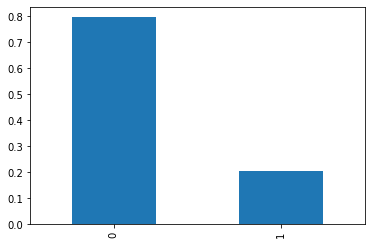

In [23]:
class_frequency = bank_churn['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Классы несбалансированы. Видим, что клиенты уходят в 20% процентах случаев, те положительный класс меньше отрицательного в 4 раза.

Проанализируем частоты классов в результатах предсказаний обеих моделей.

0    0.931
1    0.069
dtype: float64


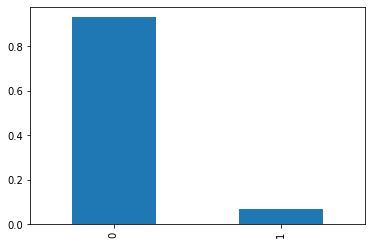

In [24]:
class_frequency_lr = predicted_valid_lr.value_counts(normalize=True)
print(class_frequency_lr)
class_frequency_lr.plot(kind='bar')

0    0.899
1    0.101
dtype: float64


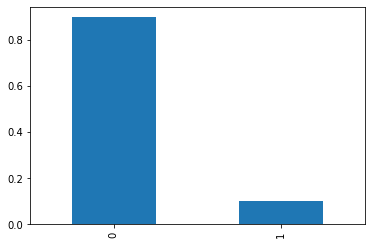

In [25]:
class_frequency_forest = predicted_valid_forest.value_counts(normalize=True)
print(class_frequency_forest)
class_frequency_forest.plot(kind='bar')

Модели предсказывают более оптимистичный расклад.

Сравним их работу с константной моделью.

In [26]:
target_pred_constant = pd.Series(0, target.index)
accuracy_score(target, target_pred_constant)

0.7963

Все же построенные модели предсказывают уход клиентов лучше, чем константная модель, они адекватны. Но можно еще улучшить результат.

Применим F1-меру (среднее гармоническое полноты и точности), чтобы оценить качество прогноза положительного класса у моделей.

In [27]:
f1_score(target_valid, predicted_valid_lr)

0.2895238095238095

In [28]:
f1_score(target_valid, predicted_valid_forest)

0.5432937181663837

 **Вывод:**
 - исследовали баланс классов - классы несбалансированы,
 - выяснили, что клиенты уходят в 20% процентах случаев, те положительный класс меньше отрицательного в 4 раза,
 - изучили модели без учёта дисбаланса
 - выяснили, что результат работы модели случайного леса лучше (возможно, только пока). 
 
 Постараемся достичь F1 не менее 0.59.

# 3. Борьба с дисбалансом

### 1. class_weight

Сбалансируем классы с помощью аргумента class_weight.

In [29]:
model = LogisticRegression(random_state=666, solver = 'liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_lr = pd.Series(model.predict(features_valid))
f1_score(target_valid, predicted_valid_lr)

0.4775330396475771

In [30]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_forest = pd.Series(model.predict(features_valid))
f1_score(target_valid, predicted_valid_forest)

0.6075949367088607

Мера F1 выглядит намного лучше, у модели LogisticRegression она увеличилась почти в 2 раза.

### 2. Уменьшение выборки

Сделаем объекты частого класса (0) не такими частыми. Для этого напишем функцию downsample.

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=666)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=666)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=666)
    
    return features_downsampled, target_downsampled

In [32]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [33]:
model = LogisticRegression(random_state=666, solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_lr = model.predict(features_valid)
f1_score(target_valid, predicted_valid_downsampled_lr)

0.3917869034406215

In [34]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666)
model.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_forest = model.predict(features_valid)
f1_score(target_valid, predicted_valid_downsampled_forest)

0.4320388349514564

Уменьшение выборки дает результаты хуже. Попробуем изменить порог.

### 3. Изменение порога

Попробуем изменить значение порога и посмотрим, как изменится F1.

In [35]:
model = LogisticRegression(random_state=666, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid_lr = model.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

In [36]:
#напишем функцию для автоматизации подсчета F1 при разном значении порога
def count_threshold (probabilities_one_valid):
    for threshold in np.arange(0, 0.6, 0.05):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | F1 = {:.3f}".format(
        threshold, f1))

In [37]:
count_threshold(probabilities_one_valid_lr)

Порог = 0.00 | F1 = 0.324
Порог = 0.05 | F1 = 0.349
Порог = 0.10 | F1 = 0.389
Порог = 0.15 | F1 = 0.434
Порог = 0.20 | F1 = 0.468
Порог = 0.25 | F1 = 0.463
Порог = 0.30 | F1 = 0.477
Порог = 0.35 | F1 = 0.448
Порог = 0.40 | F1 = 0.396
Порог = 0.45 | F1 = 0.353
Порог = 0.50 | F1 = 0.290
Порог = 0.55 | F1 = 0.261


In [38]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=666)
model.fit(features_train, target_train)
probabilities_valid_forest = model.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

In [39]:
count_threshold(probabilities_one_valid_forest)

Порог = 0.00 | F1 = 0.324
Порог = 0.05 | F1 = 0.358
Порог = 0.10 | F1 = 0.442
Порог = 0.15 | F1 = 0.525
Порог = 0.20 | F1 = 0.568
Порог = 0.25 | F1 = 0.601
Порог = 0.30 | F1 = 0.605
Порог = 0.35 | F1 = 0.594
Порог = 0.40 | F1 = 0.582
Порог = 0.45 | F1 = 0.563
Порог = 0.50 | F1 = 0.543
Порог = 0.55 | F1 = 0.511


Изменение порога показывает результаты лучше, чем уменьшение выборки.

Для модели RandomForestClassifier найдем значения **n_estimators** и **max_depth**, при которых она будет показывать лучшие результаты.

In [40]:
for depth in range(5, 11, 1):
    model = RandomForestClassifier(random_state=666, n_estimators=20, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_train_def = model.predict(features_train)
    predictions_valid_def = model.predict(features_valid)
    print("Accuracy при max_depth =", depth)
    print("Обучающая выборка:", accuracy_score(target_train, predictions_train_def))
    print("Валидационная выборка:", accuracy_score(target_valid, predictions_valid_def))
    print()

Accuracy при max_depth = 5
Обучающая выборка: 0.8595
Валидационная выборка: 0.857

Accuracy при max_depth = 6
Обучающая выборка: 0.8668333333333333
Валидационная выборка: 0.861

Accuracy при max_depth = 7
Обучающая выборка: 0.8731666666666666
Валидационная выборка: 0.863

Accuracy при max_depth = 8
Обучающая выборка: 0.8796666666666667
Валидационная выборка: 0.863

Accuracy при max_depth = 9
Обучающая выборка: 0.8873333333333333
Валидационная выборка: 0.8615

Accuracy при max_depth = 10
Обучающая выборка: 0.9003333333333333
Валидационная выборка: 0.859



In [41]:
for estim in range(40, 140, 20):
    model = RandomForestClassifier(random_state=666, n_estimators=estim, max_depth = 7)
    model.fit(features_train, target_train)
    predictions_train_def2 = model.predict(features_train)
    predictions_valid_def2 = model.predict(features_valid)
    print("Accuracy при n_estimators =", estim)
    print("Обучающая выборка:", accuracy_score(target_train, predictions_train_def2))
    print("Валидационная выборка:", accuracy_score(target_valid, predictions_valid_def2))
    print()

Accuracy при n_estimators = 40
Обучающая выборка: 0.8721666666666666
Валидационная выборка: 0.863

Accuracy при n_estimators = 60
Обучающая выборка: 0.8741666666666666
Валидационная выборка: 0.863

Accuracy при n_estimators = 80
Обучающая выборка: 0.8735
Валидационная выборка: 0.862

Accuracy при n_estimators = 100
Обучающая выборка: 0.8718333333333333
Валидационная выборка: 0.8625

Accuracy при n_estimators = 120
Обучающая выборка: 0.8721666666666666
Валидационная выборка: 0.863



**Вывод:**
- лучшие результаты показал способы борьбы с дисбалансом class_weight, применим его
- работать дальше будем с моделью RandomForestClassifier со значением n_estimators = 40 и max_depth = 9

# 4. Тестирование модели

Обучим финальную модель и проверим её на тестовой выборке.

In [42]:
model_final = RandomForestClassifier(random_state=666, n_estimators=40, max_depth = 9, class_weight='balanced')
model_final.fit(features_train, target_train)
predicted_test = model_final.predict(features_test)
f1_score(target_test, predicted_test)

0.6125714285714287

Нужное значение F1-меры достигнуто.

Посчитаем площадь под ROC-кривой для модели (**AUC-ROC**), чтобы узнать, насколько сильно ее точность отличается от случайной.

In [46]:
probabilities_valid_final = model_final.predict_proba(features_valid)
probabilities_one_valid_final = probabilities_valid_final[:, 1]
roc_auc_score(target_test, probabilities_one_valid_final)

0.49548732285588

Метрика AUC-ROC почти не отличается от значения для случайной модели (0.5). F1 оценила построенную модель выше.

## Общий вывод

1. Ознакомились с данными и подготовили их к исследованию (преобразовали категориальные признаки в численные с помощью техники прямого кодирования One-Hot Encoding,разбили получившийся датасет на 3 выборки - обучающую, валидационную и тестовую, масштабировали признаки методом стандартизации).


2. Исследовали баланс классов - они оказались несбалансированы, изучили модели без учёта дисбаланса, выяснили, что результат работы модели случайного леса лучше.


3. Применили 3 способа борбы с дисбалансом - аргумент class_weight, уменьшение выборки и изменение порога. Лучшие результаты показал способы борьбы с дисбалансом class_weight. Выявили лучшие значения n_estimators и max_depth для модели случайного леса.


4. Обучили финальную модель и проверили ее на тестовой выборке. Достигли значения F1 = 0.61. Исследовали метрику AUC-ROC - ее значение в данном случае почти не отличается от значения для случайной модели (0.5)